In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import numpy as np
import os
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_dir = '/kaggle/input/flowers-recognition/flowers'
labels = ['daisy','dandelion','rose','sunflower','tulip']
x = []
y = []
for label in labels:
    data = os.path.join(data_dir,label)
    for image in os.listdir(data):
        try:
            im = cv2.imread(os.path.join(data,image),cv2.IMREAD_COLOR)
            im = cv2.resize(im,(128,128))
            # Using the Canny filter with different parameters
            
            x.append(im)
            y.append(labels.index(label))
            
        except Exception as e:
            pass

In [3]:
np.unique(y)

array([0, 1, 2, 3, 4])

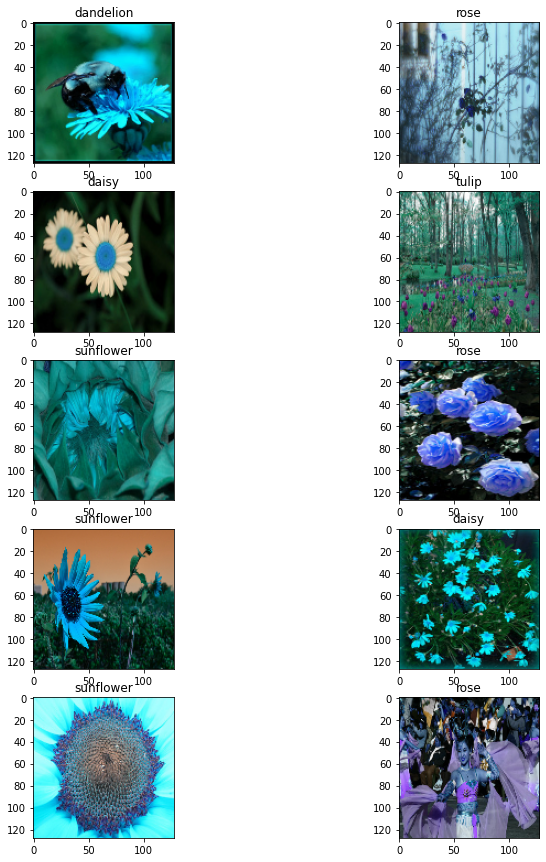

In [4]:
import matplotlib.pyplot as plt
import random
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(12,15)
for i in range(5):
    for j in range(2):
        ran =random.randint(0,len(x))
        ax[i, j].imshow(x[ran])
        ax[i, j].set_title(labels[y[ran]])

In [5]:
x = np.array(x)/255.0
y = np.array(y)
x =x.reshape(-1,128,128,3)
y= y.reshape(-1,1)
y= tf.keras.utils.to_categorical(y,5,)

In [6]:
datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
fill_mode= 'nearest',
horizontal_flip=False,
vertical_flip=False,
shear_range=0.1,
zoom_range = 0.1, # Randomly zoom image 
width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.2
)
datagenerator.fit(x)

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [8]:
from tensorflow.keras.applications import VGG19
vgg = VGG19(include_top=False,weights = 'imagenet',classes=5,input_shape=(128,128,3))

for layer in vgg.layers[:17]:
    layer.trainable=False

from keras.regularizers import l2    
model = tf.keras.Sequential()
model.add(vgg)
model.add(tf.keras.layers.Conv2D(128,(5,5),padding ='same',strides=(2,2),activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(256,(5,5),padding ='same',strides=(2,2),activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5,activation='softmax'))

80142336/80134624 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 128)         1638528   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 256)         819456    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 22,483,653
Trainable params: 11,898,501
Non-trainable params: 10,585,152
___________________________________

In [10]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

In [ ]:
history =model.fit(datagenerator.flow(x_train,y_train,batch_size=64),steps_per_epoch=len(x_train) / 64,epochs=30,callbacks=[earlystop],validation_data=datagenerator.flow(x_test,y_test))

Epoch 1/30
48/50 [===========================>..] - ETA: 0s - loss: 1.6223 - accuracy: 0.2301

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val'],loc='upper right')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'],loc='upper right')

In [ ]:
train_loss, train_acc = model.evaluate(x_train, y_train)
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Accuracy on train set is %f" %(train_acc * 100)  + "%")
print("Accuracy on validation set is %f" %(test_acc * 100)  + "%")